In [1]:
%%capture --no-stderr
%pip install datasets evaluate transformers[torch]

In [27]:
import os
import getpass
import numpy as np
import torch
from datasets import load_dataset
import evaluate

In [4]:
# load the necessary secrets
os.environ['OPENAI_API_KEY'] = getpass.getpass()
os.environ['HF_TOKEN'] = getpass.getpass()

··········
··········


In [5]:
model = 'roberta-base' # base model
task = 'mrpc' # Microsoft Research Paraphrase Corpus to see if two sentences are paraphrases

In [6]:
dataset = load_dataset('glue', task) # General Language Understanding Evaluation

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

* The dataset includes data for training, validation, and test with appropraite features.

In [15]:
train_ds = dataset['train']
train_ds[0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

* For each part of the data, it consists two sentences (for comparison), label (output status), and index.

In [21]:
# evaluation metric
metric = evaluate.load('glue', task)

In [12]:
# load pretrained tokenizer and transformer model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load the appropriate model and pad input tokens to the right
tokenizer = AutoTokenizer.from_pretrained(model, padding_side = 'right')

# function to tokenize two sentences
def tokenize_function(examples):
  outputs = tokenizer(examples['sentence1'], examples['sentence2'], max_length = None, truncation = True)
  return outputs
# this function tokenize two sentences for comparing with maximum length set as the deafult of the model,
# and truncates the sentence if it exceeds the maximum

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
# tokenize the entire dataset and remove unnecessary columns
tokenized_data = dataset.map(tokenize_function, batched = True, remove_columns = ['sentence1', 'sentence2', 'idx'])
# rename label into labels
tokenized_data = tokenized_data.rename_column('label', 'labels')

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

* Transformers usually expect the target variable to be named labels (not label).

In [14]:
tokenized_data['train'].features

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 3668
})

In [17]:
ttrain_ds = tokenized_data['train']
print(ttrain_ds[0])

{'labels': 1, 'input_ids': [0, 10127, 1001, 6182, 1238, 39, 2138, 2156, 2661, 37, 373, 22, 5, 4562, 22, 2156, 9, 12507, 7018, 23817, 39, 1283, 479, 2, 2, 48310, 4506, 7, 123, 25, 129, 22, 5, 4562, 22, 2156, 1918, 1001, 6182, 1238, 39, 2138, 9, 12507, 7018, 23817, 39, 1283, 479, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


* Now all the inputs are tokenized.
* The 1s in the attention mask indicates that the sequence did not require padding, fitting within the model's maximum length.

In [18]:
# pretrained transformer model with classification head, returns dictionary as output
mod = AutoModelForSequenceClassification.from_pretrained(model, return_dict = True)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# the sum of the parameters in the model
sum(p.numel() for p in mod.parameters())

124647170

* Now the ground work for data processing is complete.

In [23]:
# function to return
def compute_metrics(evaluation_pred):

  """
  evauation_pred: consist of logits (raw output scores) and labels (true labels)
  the logits will be converted to labels by returning the index of the highest value.
  """
  predictions, labels = evaluation_pred
  predictions = np.argmax(predictions, axis = 1)
  return metric.compute(predictions = predictions, references = labels)

* This function returns training loss, validation loss, f1, and accuracy by comparing the predictions and the actual labels.

In [24]:
# lora configuration for fine-tuning
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType
    )

lora_config = LoraConfig(task_type = TaskType.SEQ_CLS, # task type: sequence classification
                       r = 32, # setting the rank of the trainable parameters
                       lora_alpha = 1, # scaling factor
                       lora_dropout = 0.1 # dropouts during training for regularizaTION
                         )

In [25]:
# initialize lora model with lora config
lora_model = get_peft_model(mod, lora_config)
lora_model.print_trainable_parameters()

trainable params: 1,771,778 || all params: 126,418,948 || trainable%: 1.4015


* We will train approx 1.4 percent of the parameters.

In [26]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

# setting the training arguments
training_args = TrainingArguments(
    output_dir = './my_model_output',
    learning_rate = 1e-3,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    num_train_epochs = 5,
    weight_decay = 0.01,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    logging_steps = 100,
    load_best_model_at_end = True
)

In [30]:
# set gpu device for faster and more accurate results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [31]:
# set data collator
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, padding = 'longest')

* This enables the model to pad each sequence in the bath to the length of the longest.

In [33]:
trainer = Trainer(
    model = lora_model.to(device), # use GPU environment for the model
    args = training_args, # training arguments
    train_dataset = tokenized_data['train'],
    eval_dataset = tokenized_data['test'],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

trainer.train()

<ipython-input-33-01da6a662006>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: taegeonyoo041 (taegeonyoo041-saint-louis-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.543490,0.720580,0.817424
2,0.574500,0.444462,0.790145,0.851882
3,0.574500,0.412789,0.802899,0.864542
4,0.451200,0.372851,0.827246,0.875626
5,0.451200,0.367684,0.829565,0.876781


TrainOutput(global_step=290, training_loss=0.4748317192340719, metrics={'train_runtime': 231.6448, 'train_samples_per_second': 79.173, 'train_steps_per_second': 1.252, 'total_flos': 809637729543840.0, 'train_loss': 0.4748317192340719, 'epoch': 5.0})

Training Process:

1. Loads batches using the data collator.
2. Feeds inputs to lora model
3. Calculates loss and backpropagates through lora parameters
  * forward pass: compute logits (raw model predictions)
  * loss calculation: compare logits to true labels and get error rate
  * backward pass: compute the gradient of the loss, determining how each trainable parameter contributed to the error
  * optimizing: optimize the results by updating only the LoRA adapter weights

* The accuracy and f1 score is getting higher with more epochs and loss rate getting smaller.

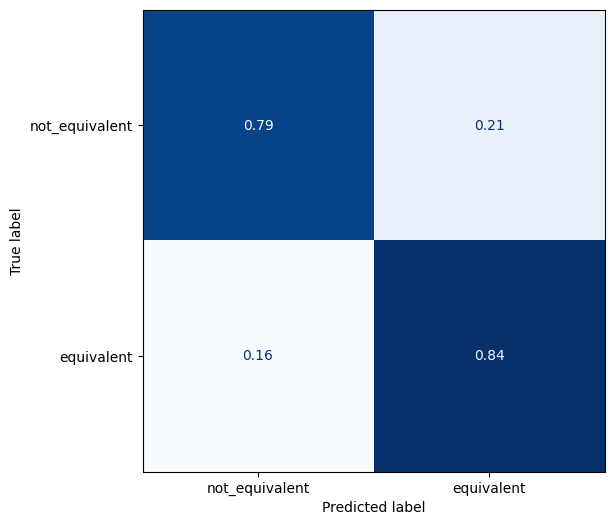

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# function to plot confusion matrix
def cm(y_pred, y_true, labels):
  cm = confusion_matrix(y_pred, y_true, normalize = 'true')
  fig, ax = plt.subplots(figsize = (6, 6))
  display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  display.plot(cmap = 'Blues', values_format='.2f', ax = ax, colorbar=False)
  plt.show()

# predicrtions
y_preds = np.argmax(trainer.predict(tokenized_data['test']).predictions, axis = 1)
# true labels
y_true = tokenized_data['test']['labels']
# column names
labels = dataset['test'].features['label'].names
# plot
cm(y_preds, y_true, labels)

* The results show decent True Positives/Negatives.